In [1]:
#from utility_bfvariater import *
from utility_bfcombiner import *
from utility_common import *
from utility_commonPlot import *
from scipy.stats import multivariate_normal
%matplotlib inline


In [2]:
def get_delta(beta_mean,beta_covar):
    delta_mean = (beta_mean - beta_mean[2])[0:2]
    delta_covar = np.array([[beta_covar[0,0]+beta_covar[2,2]-2*beta_covar[0,2],
                             beta_covar[0,1] - beta_covar[0,2] - beta_covar[1,2] + beta_covar[2,2]],
                            [beta_covar[0,1] - beta_covar[0,2] - beta_covar[1,2] + beta_covar[2,2],
                             beta_covar[1,1]+beta_covar[2,2]-2*beta_covar[1,2]]
                           ])  
    return delta_mean, delta_covar

In [3]:
beta_mean = np.load("../data/combine/beta_mean.npy")*100
beta_covar = np.load("../data/combine/beta_covar.npy")*100**2
delta_mean, delta_covar = get_delta(beta_mean,beta_covar)
rv = multivariate_normal(delta_mean, delta_covar)
delta_invcovar=np.linalg.inv(delta_covar)
delta_eigenStd = 1/np.linalg.eigvals(delta_invcovar)**0.5
print("delta_eigenStd", delta_eigenStd)


#PDG
pdgbeta_mean=np.array([10.71, 10.63, 11.38])
pdgbeta_sigma=np.array([0.16, 0.15, 0.21])
pdgbeta_covar= np.outer(pdgbeta_sigma,pdgbeta_sigma)
def getcovar(i,j,fstd):
    fvar = fstd**2
    f = pdgbeta_mean[i]/pdgbeta_mean[j]
    # print(f,fstd)
    value =  pdgbeta_covar[i,i]/pdgbeta_mean[i]**2 + pdgbeta_covar[j,j]/pdgbeta_mean[j]**2 -  fvar/f**2
    value *= 0.5*pdgbeta_mean[i]*pdgbeta_mean[j]
    pdgbeta_covar[i,j] = value
    pdgbeta_covar[j,i] = value

getcovar(1,0, 0.013)
getcovar(2,0, 0.024)
getcovar(2,1, 0.026)

pdgdelta_mean, pdgdelta_covar = get_delta(pdgbeta_mean,pdgbeta_covar)
pdgrv = multivariate_normal(pdgdelta_mean, pdgdelta_covar)
pdgdelta_invcovar=np.linalg.inv(pdgdelta_covar)
pdgdelta_eigenStd = 1/np.linalg.eigvals(pdgdelta_invcovar)**0.5
print("pdgdelta_eigenStd", pdgdelta_eigenStd)

delta_eigenStd [0.16187613 1.02528308]
pdgdelta_eigenStd [0.09789207 0.35533415]


In [4]:
a = pdgbeta_covar/np.outer(pdgbeta_sigma,pdgbeta_sigma)
np.save('../data/combine/pdgbeta_corr',a)

In [5]:
pdgbeta_covar

array([[ 0.0256    ,  0.01427361,  0.0032627 ],
       [ 0.01427361,  0.0225    , -0.00303531],
       [ 0.0032627 , -0.00303531,  0.0441    ]])

In [6]:
# Our 2-dimensional distribution will be over variables X and Y
N = 3000
x = np.linspace(-1.5, 1.5, N)
y = np.linspace(-1.5, 1.5, N)
X, Y = np.meshgrid(x, y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

In [7]:
nll    = -rv.logpdf(pos) + rv.logpdf(delta_mean)
pdgnll = -pdgrv.logpdf(pos) + pdgrv.logpdf(pdgdelta_mean)

def get_pvalue(Z, point):
    points = np.array(point)
    deltax = x[1]-x[0]
    integral = Z[Z>rv.pdf(point)].sum() * deltax**2
    pvalue = 1-integral
    return pvalue
         
Z = rv.pdf(pos)
pvalue = get_pvalue(Z, [0,0])

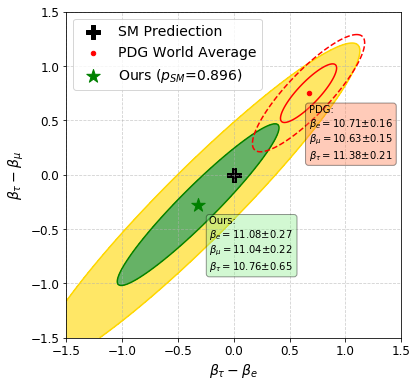

In [18]:
plt.figure(figsize=(6,6),facecolor='w')
plt.contourf(-X, -Y, nll,[0, 0.5, 2],colors=["green","gold"],alpha=0.6)
plt.contour(-X, -Y, nll,[ 0.5, 2],colors=["green","gold"],alpha=1)

plt.contour(-X, -Y, pdgnll,[ 0.5, 2],colors=["red","red"],alpha=1,linestyles=["-","--"])

plt.scatter(0,0,color='k',marker='P',s=200,label="SM Prediection")
plt.scatter(-pdgdelta_mean[0],-pdgdelta_mean[1],color='r',marker='o',s=20,label="PDG World Average")
plt.scatter(-delta_mean[0],-delta_mean[1],color='g',marker='*',s=200,label="Ours "+r"($p_{SM}$="+ "{:4.3})".format(pvalue))

plt.grid(linestyle="--",alpha=0.6)
plt.xticks([-1.5, -1,-.5,0,0.5,1,1.5],fontsize=12)
plt.yticks([-1.5,-1,-.5,0,0.5,1,1.5],fontsize=12)
plt.xlabel(r"$\beta_\tau-\beta_e$",fontsize=14)
plt.ylabel(r"$\beta_\tau-\beta_\mu$",fontsize=14)
plt.legend(loc="upper left",fontsize=14)

pdgbetaText = "PDG:"
pdgbetaText = pdgbetaText +" \n" + r"$\beta_{e}   =$" + r"{:4.2f}$\pm${:4.2f}".format(pdgbeta_mean[0],pdgbeta_covar[0,0]**0.5)
pdgbetaText = pdgbetaText +" \n" + r"$\beta_{\mu} =$" + r"{:4.2f}$\pm${:4.2f}".format(pdgbeta_mean[1],pdgbeta_covar[1,1]**0.5)
pdgbetaText = pdgbetaText +" \n" + r"$\beta_{\tau}=$" + r"{:4.2f}$\pm${:4.2f}".format(pdgbeta_mean[2],pdgbeta_covar[2,2]**0.5)
props = dict(boxstyle='round', facecolor='coral', alpha=0.4, edgecolor="k")
plt.text(-pdgdelta_mean[0],-pdgdelta_mean[1]-0.1,pdgbetaText, verticalalignment='top', bbox=props)

betaText = "Ours:"
betaText = betaText +" \n" + r"$\beta_{e}   =$" + r"{:4.2f}$\pm${:4.2f}".format(beta_mean[0],beta_covar[0,0]**0.5)
betaText = betaText +" \n" + r"$\beta_{\mu} =$" + r"{:4.2f}$\pm${:4.2f}".format(beta_mean[1],beta_covar[1,1]**0.5)
betaText = betaText +" \n" + r"$\beta_{\tau}=$" + r"{:4.2f}$\pm${:4.2f}".format(beta_mean[2],beta_covar[2,2]**0.5)
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.4, edgecolor="k")
plt.text(-delta_mean[0]+0.1,-delta_mean[1]-0.1,betaText, verticalalignment='top', bbox=props)


plt.savefig('../plots/combine/delta.png',dpi=300)

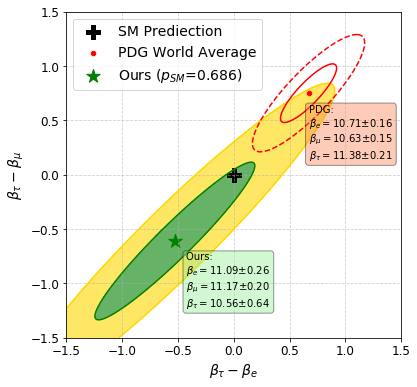

In [10]:
plt.figure(figsize=(6,6),facecolor='w')
plt.contourf(-X, -Y, nll,[0, 0.5, 2],colors=["green","gold"],alpha=0.6)
plt.contour(-X, -Y, nll,[ 0.5, 2],colors=["green","gold"],alpha=1)

plt.contour(-X, -Y, pdgnll,[ 0.5, 2],colors=["red","red"],alpha=1,linestyles=["-","--"])

plt.scatter(0,0,color='k',marker='P',s=200,label="SM Prediection")
plt.scatter(-pdgdelta_mean[0],-pdgdelta_mean[1],color='r',marker='o',s=20,label="PDG World Average")
plt.scatter(-delta_mean[0],-delta_mean[1],color='g',marker='*',s=200,label="Ours "+r"($p_{SM}$="+ "{:4.3})".format(pvalue))

plt.grid(linestyle="--",alpha=0.6)
plt.xticks([-1.5, -1,-.5,0,0.5,1,1.5],fontsize=12)
plt.yticks([-1.5,-1,-.5,0,0.5,1,1.5],fontsize=12)
plt.xlabel(r"$\beta_\tau-\beta_e$",fontsize=14)
plt.ylabel(r"$\beta_\tau-\beta_\mu$",fontsize=14)
plt.legend(loc="upper left",fontsize=14)

pdgbetaText = "PDG:"
pdgbetaText = pdgbetaText +" \n" + r"$\beta_{e}   =$" + r"{:4.2f}$\pm${:4.2f}".format(pdgbeta_mean[0],pdgbeta_covar[0,0]**0.5)
pdgbetaText = pdgbetaText +" \n" + r"$\beta_{\mu} =$" + r"{:4.2f}$\pm${:4.2f}".format(pdgbeta_mean[1],pdgbeta_covar[1,1]**0.5)
pdgbetaText = pdgbetaText +" \n" + r"$\beta_{\tau}=$" + r"{:4.2f}$\pm${:4.2f}".format(pdgbeta_mean[2],pdgbeta_covar[2,2]**0.5)
props = dict(boxstyle='round', facecolor='coral', alpha=0.4, edgecolor="k")
plt.text(-pdgdelta_mean[0],-pdgdelta_mean[1]-0.1,pdgbetaText, verticalalignment='top', bbox=props)

betaText = "Ours:"
betaText = betaText +" \n" + r"$\beta_{e}   =$" + r"{:4.2f}$\pm${:4.2f}".format(beta_mean[0],beta_covar[0,0]**0.5)
betaText = betaText +" \n" + r"$\beta_{\mu} =$" + r"{:4.2f}$\pm${:4.2f}".format(beta_mean[1],beta_covar[1,1]**0.5)
betaText = betaText +" \n" + r"$\beta_{\tau}=$" + r"{:4.2f}$\pm${:4.2f}".format(beta_mean[2],beta_covar[2,2]**0.5)
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.4, edgecolor="k")
plt.text(-delta_mean[0]+0.1,-delta_mean[1]-0.1,betaText, verticalalignment='top', bbox=props)


plt.savefig('../plots/combine/delta.png',dpi=300)

In [24]:
# C = np.linalg.cholesky(delta_covar)
# x = np.random.normal(0,1,(10000,2))
# x = np.matmul(C,x.T)
# x = delta_mean[:,None] + x

In [25]:
1 - get_pvalue(Z, [-.5,-.49])

0.4180245184541822

In [26]:
-pdgrv.logpdf([-.5,-.4916]) + pdgrv.logpdf(pdgdelta_mean)

0.499973517733038

In [27]:
be

array([[ 0.07081036,  0.03274885, -0.00517808],
       [ 0.03274885,  0.0410471 , -0.02774582],
       [-0.00517808, -0.02774582,  0.43766902]])

In [16]:
sqrt(0.4195294525030464)

0.6477109328265552

In [ ]:


# def get_pvalue_for_pos(rv):
    
#     Z = rv.pdf(pos)
#     result = np.zeros_like(Z)
    
#     for i in range(N):
#         for j in range(N):
#             point = pos[i,j]
#             result[i,j] = get_pvalue(Z, point)
#     return result

# pvalues = get_pvalue_for_pos(rv)
# pdgpvalues = get_pvalue_for_pos(pdgrv)   